# 📈 Manuscript Data and Figure Generation Notebook

## 0. ⚙️ Setup
### Installations
Install all necessary libraries.
**Note**: If you are running this in a new environment, you might need to uncomment and run this cell.

In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn sentence-transformers tqdm google-generativeai shap scipy umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 30.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

### Data Storage for Prompt Generation
These dictionaries are used to convert numerical features into human-readable narratives for the Gemini model prompts.

In [2]:
binary_narratives = {
    "highchol": {1: "has high cholesterol", 0: "does not have high cholesterol"},
    "stroke": {1: "has had a stroke", 0: "has not had a stroke"},
    "diffwalk": {1: "has difficulty walking", 0: "can walk without difficulty"},
    "highbp": {1: "has high blood pressure", 0: "does not have high blood pressure"},
    "cholcheck": {1: "has had cholesterol checked", 0: "has not had cholesterol checked"},
    "smoker": {1: "is a smoker", 0: "is not a smoker"},
    "physactivity": {1: "does physical activity", 0: "does not do physical activity"},
    "fruits": {1: "eats fruits", 0: "does not eat fruits"},
    "veggies": {1: "eats vegetables", 0: "does not eat vegetables"},
    "hvyalcoholconsump": {1: "consumes heavy alcohol", 0: "does not consume heavy alcohol"},
    "anyhealthcare": {1: "has healthcare access", 0: "does not have healthcare access"},
    "nodocbccost": {1: "avoided doctor due to cost", 0: "did not avoid doctor due to cost"},
    "sex": {1: "is male", 0: "is female"},
}

age_map = {
    1: "18-24 years old", 2: "25-29 years old", 3: "30-34 years old",
    4: "35-39 years old", 5: "40-44 years old", 6: "45-49 years old",
    7: "50-54 years old", 8: "55-59 years old", 9: "60-64 years old",
    10: "65 years or older"
}

education_map = {
    1: "no schooling completed", 2: "completed elementary school",
    3: "not finished high school", 4: "completed high school",
    5: "attended some college but didn't complete it", 6: "graduated college",
    7: "a postgraduate education"
}

income_map = {
    1: "an income less than $10,000", 2: "an income $10,000-$14,999",
    3: "an income between $15,000 and $19,999", 4: "an income between $20,000 and $24,999",
    5: "an income between $25,000 and $34,999", 6: "an income between $35,000 and $49,999",
    7: "an income between $50,000 and $74,999", 8: "an income between $75,000 and $99,999",
    9: "an income between $100,000 and $149,999", 10: "an income above $150,000"
}

### Imports
Import all necessary Python libraries for data manipulation, machine learning, plotting, and LLM interaction.

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
# from google.colab import userdata # Uncomment if running in Google Colab and using userdata
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from scipy.stats import ttest_rel, uniform, randint
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from umap import UMAP # Requires `!pip install umap-learn` if not already installed
import shap
from xgboost import XGBClassifier
import joblib
import time
import google.generativeai as genai

# Create a directory for figures if it doesn't exist
FIGURES_DIR = 'figures'
os.makedirs(FIGURES_DIR, exist_ok=True)

### Function Definitions
Re-defining utility functions from your original notebook for data evaluation, plotting, and prompt generation.

In [4]:
def evaluate_and_print_metrics(model_name, y_true, y_pred, phase="", print_confusion_matrix=True, save_path=None):
    """
    Calculates and prints key classification metrics and optionally displays/saves a confusion matrix.
    """
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)

    print(f"-- {model_name} {phase} Metrics --")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"\nClassification Report:\n{classification_report(y_true, y_pred)}")

    if print_confusion_matrix:
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Pred Neg','Pred Pos'], yticklabels=['True Neg','True Pos'])
        plt.title(f'{model_name} {phase} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Saved confusion matrix to {save_path}")
        plt.show()
    return {'accuracy': accuracy, 'recall': recall, 'f1_score': f1, 'report': report}

def clean_data(df, feats):
    """
    Cleans specified features in a DataFrame by replacing 0s with NaN and then imputing NaNs with the median.
    """
    df = df.copy()
    for col in feats:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            # Replace 0s with NaN only for columns where 0 is not a meaningful value (e.g., BloodPressure, BMI)
            # This needs careful consideration based on the dataset. For simplicity, applying to all numeric feats.
            # In a real scenario, you'd specify which columns 0 means missing.
            if col not in ['pregnancies', 'cholcheck', 'smoker', 'stroke', 'heartdiseaseorattack', 'physactivity', 'fruits', 'veggies', 'hvyalcoholconsump', 'anyhealthcare', 'nodocbccost', 'diffwalk', 'sex']: # These can legitimately be 0
                df[col] = df[col].replace(0, np.nan)
            df[col] = df[col].fillna(df[col].median())
        else:
            print(f"⚠️ Skipping non-numeric or missing feature: {col}")
    return df

def plot_roc_curve(y_true, y_scores, model_name="Model", ax=None, save_path=None):
    """
    Plots the ROC curve.
    """
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    if ax:
        ax.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve - {model_name}')
        ax.legend(loc="lower right")
    if save_path and ax is None: # If no ax is provided, create a new figure
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.savefig(save_path, bbox_inches='tight')
        plt.close() # Close the figure to prevent display in notebook
        print(f"Saved ROC curve to {save_path}")
    return roc_auc

def generate_prompts(df):
    """
    Generates natural language prompts from patient data for LLM input.
    """
    prompts = []
    for _, row in df.iterrows():
        parts = []

        # 1. Demographic background
        if 'source' in row and pd.notna(row['source']):
            if row['source'] == 'CDC':
                parts.append("is of American background")
            elif row['source'] == 'PIMA':
                parts.append("is of Native American (Pima) background")

        # 2. Age
        if 'age' in row and pd.notna(row['age']):
            age_val = int(row['age'])
            age_str = age_map.get(age_val, f"age category {age_val}")
            parts.append(f"is {age_str}")

        # 3. Sex
        if 'sex' in row and row['sex'] in binary_narratives['sex']:
            parts.append(binary_narratives['sex'][row['sex']])

        # 4. Education
        if 'education' in row and pd.notna(row['education']):
            edu_val = int(row['education'])
            edu_str = education_map.get(edu_val, f"education level {edu_val}")
            parts.append(f"has {edu_str}")

        # 5. Income
        if 'income' in row and pd.notna(row['income']):
            income_val = int(row['income'])
            income_str = income_map.get(income_val, f"income level {income_val}")
            parts.append(f"has {income_str}")

        # 6. Binary health flags
        for col in binary_narratives:
            if col in row and pd.notna(row[col]):
                parts.append(binary_narratives[col].get(row[col], f"{col} {row[col]}"))

        # 7. Numerical features (exclude known categorical/binary columns)
        skip_cols = set(['label', 'source', 'age', 'sex', 'education', 'income']).union(binary_narratives.keys())
        for col, val in row.items():
            if col in skip_cols:
                continue
            if pd.isna(val):
                continue
            try:
                val_float = float(val)
                sval = f"{int(val_float)}" if val_float.is_integer() else f"{val_float:.1f}"
            except:
                sval = str(val)
            parts.append(f"{col.replace('_', ' ')} {sval}")

        prompt = "Patient who " + ", ".join(parts) + "."
        prompts.append(prompt)
    return prompts

def gemini_predict_limited(df, model_name='gemini-2.0-flash', limit=400, save_path='gemini_preds.csv'):
    """
    Calls the Gemini API for a limited number of predictions and saves them.
    Includes rate limiting and error handling.
    """
    # Configure the Gemini API key. Replace 'YOUR_API_KEY' with your actual API key.
    # It's recommended to use a secure method for API keys (e.g., environment variables).
    # If running in Google Colab, you can use `userdata.get('GEMINI_API_KEY')`.
    # For this example, we'll use a placeholder.
    try:
        genai.configure(api_key=os.environ.get("GEMINI_API_KEY", "YOUR_GEMINI_API_KEY_HERE"))
    except Exception as e:
        print(f"Error configuring Gemini API: {e}. Please ensure your API key is set correctly.")
        print("Skipping Gemini prediction as API key is not configured.")
        return pd.DataFrame() # Return empty DataFrame if API key is not set

    model = genai.GenerativeModel(model_name)

    if df.empty:
        print("Provided DataFrame is empty for Gemini prediction.")
        return pd.DataFrame()

    df_done = pd.DataFrame(columns=['index', 'prompt', 'label', 'prediction'])
    if os.path.exists(save_path):
        try:
            df_done = pd.read_csv(save_path)
            print(f"Loaded {len(df_done)} previous predictions from {save_path}.")
        except pd.errors.EmptyDataError:
            print(f"Existing file {save_path} is empty. Starting fresh.")
        except Exception as e:
            print(f"Error loading existing predictions from {save_path}: {e}. Starting fresh.")

    done_indices = set(df_done['index'].astype(int))
    prompts = generate_prompts(df)
    call_count = 0
    rows_to_append = []

    print(f"Starting Gemini predictions. Limit: {limit} calls.")
    for i, row in enumerate(tqdm(df.itertuples(index=False), total=len(df))):
        if call_count >= limit:
            print(f"Reached API call limit of {limit}. Stopping.")
            break
        if i in done_indices:
            continue # Skip already processed indices

        prompt = prompts[i]
        label = int(getattr(row, 'label', 0)) # Assuming 'label' column exists in the input df

        try:
            # print(f"Calling Gemini for prompt {i}...")
            result = model.generate_content([
                "You are a medical assistant AI that predicts diabetes risk based on patient information. Use the demographics (such as age, gender, and background) along with health indicators to decide.",
                "Your task is to reply with either 0 (doesn't have diabetes) or 1 (might have diabetes). Respond with a single digit only.",
                prompt
            ])
            # print(f"Received result for prompt {i}")

            if result.text.strip():
                try:
                    pred = int(result.text.strip())
                    if pred not in [0, 1]:
                        raise ValueError("Invalid prediction format")
                except ValueError:
                    # Fallback for non-integer or malformed responses
                    print(f"Warning: Gemini returned non-binary prediction '{result.text.strip()}' for index {i}. Attempting conversion.")
                    try:
                        pred = int(float(result.text.strip()) > 0.5)
                    except ValueError:
                        print(f"Could not parse prediction for index {i}. Defaulting to 0.")
                        pred = 0 # Default to 0 if parsing fails
            else:
                print(f"Warning: Empty response from Gemini for index {i}. Defaulting to 0.")
                pred = 0 # Default to 0 if response is empty

            rows_to_append.append({'index': i, 'prompt': prompt, 'label': label, 'prediction': pred})
            call_count += 1
            # print(f"{call_count}/{limit} ✓ Prompt {i}")

            # Save periodically to avoid data loss on interruption
            if len(rows_to_append) >= 50: # Save every 50 new predictions
                append_mode = os.path.isfile(save_path) and os.path.getsize(save_path) > 0
                pd.DataFrame(rows_to_append).to_csv(save_path, mode='a', header=not append_mode, index=False)
                rows_to_append.clear()
                df_done = pd.read_csv(save_path) # Reload to update done_indices
                done_indices = set(df_done['index'].astype(int))

            time.sleep(2.5) # Rate limit to avoid hitting API quotas

        except Exception as e:
            print(f"⚠️ Error on index {i}: {str(e)}")
            if "429" in str(e) or "quota" in str(e).lower() or "timeout" in str(e).lower():
                print("🚨 Quota exceeded or timeout detected. Stopping further API calls.")
                break
            continue # Continue to next iteration on other errors

    print("Finished or reached API limit for Gemini predictions.")
    # Append any remaining rows
    if rows_to_append:
        append_mode = os.path.isfile(save_path) and os.path.getsize(save_path) > 0
        pd.DataFrame(rows_to_append).to_csv(save_path, mode='a', header=not append_mode, index=False)

    # Final load of all predictions
    if os.path.exists(save_path):
        df_final = pd.read_csv(save_path)
    else:
        df_final = pd.DataFrame() # Should not happen if rows_to_append was not empty

    if df_final.empty or 'prediction' not in df_final or df_final['prediction'].dropna().empty:
        print("No valid Gemini predictions available to evaluate.")
        return df_final

    y_true_gemini = df_final['label'].astype(int)
    y_pred_gemini = df_final['prediction'].astype(int)
    evaluate_and_print_metrics("Gemini", y_true_gemini, y_pred_gemini, phase=f"on {len(df_final)} prompts",
                               print_confusion_matrix=True, save_path=os.path.join(FIGURES_DIR, 'gemini_confusion_matrix.png'))
    return df_final

## 1. 🧹 Data Cleaning & Processing
Replicate the data loading and preprocessing steps from your `Final_Full_Code.ipynb`.

### 1.1 Load PIMA CSV
Loads the PIMA Indians Diabetes dataset.

In [5]:
pima_path = '/content/pima-indians-diabetes.csv'
# Check if the file exists, if not, provide a dummy DataFrame
if not os.path.exists(pima_path):
    print(f"Warning: {pima_path} not found. Creating a dummy PIMA DataFrame.")
    df_pima = pd.DataFrame(np.random.rand(100, 9), columns=['pregnancies','glucose','bloodpressure','skinthickness','insulin','bmi','pedigree','age','class'])
    df_pima['class'] = np.random.randint(0, 2, 100)
else:
    df_pima = pd.read_csv(pima_path)
df_pima['source'] = 'PIMA' # Add source column to PIMA

### 1.2 Load CDC files from the "contest" folder
Loads and concatenates the CDC diabetes health indicators datasets.

In [6]:
cdc_paths = [
    '/content/diabetes_012_health_indicators_BRFSS2015.csv',
    '/content/diabetes_binary_5050split_health_indicators_BRFSS2015.csv',
    '/content/diabetes_binary_health_indicators_BRFSS2015.csv'
]

df_cdc_list = []
for path in cdc_paths:
    if not os.path.exists(path):
        print(f"Warning: {path} not found. Skipping this CDC file.")
    else:
        df_cdc_list.append(pd.read_csv(path))

if not df_cdc_list:
    print("No CDC files found. Creating a dummy CDC DataFrame.")
    df_cdc = pd.DataFrame(np.random.rand(100, 22), columns=[
        'diabetes_012', 'highbp', 'highchol', 'cholcheck', 'bmi', 'smoker', 'stroke',
        'heartdiseaseorattack', 'physactivity', 'fruits', 'veggies', 'hvyalcoholconsump',
        'anyhealthcare', 'nodocbccost', 'genhlth', 'menthlth', 'physhlth', 'diffwalk',
        'sex', 'age', 'education', 'income'
    ])
    df_cdc['diabetes_012'] = np.random.randint(0, 3, 100)
    df_cdc['diabetes_binary'] = df_cdc['diabetes_012'].apply(lambda x: 1 if x == 2 else 0)
else:
    df_cdc = pd.concat(df_cdc_list, axis=0, ignore_index=True)
df_cdc['source'] = 'CDC' # Add source column to CDC combined data

### 1.3 Clean column names
Standardizes column names to lowercase and replaces spaces with underscores.

In [7]:
for df in [df_pima, df_cdc]:
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

print("📘 PIMA columns after clean:", df_pima.columns.tolist())
print("📘 CDC columns after clean:", df_cdc.columns.tolist())

📘 PIMA columns after clean: ['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi', 'pedigree', 'age', 'class', 'source']
📘 CDC columns after clean: ['diabetes_012', 'highbp', 'highchol', 'cholcheck', 'bmi', 'smoker', 'stroke', 'heartdiseaseorattack', 'physactivity', 'fruits', 'veggies', 'hvyalcoholconsump', 'anyhealthcare', 'nodocbccost', 'genhlth', 'menthlth', 'physhlth', 'diffwalk', 'sex', 'age', 'education', 'income', 'diabetes_binary', 'source']


### 1.4 Identify PIMA label column
Determines the target variable column for the PIMA dataset.

In [8]:
if 'outcome' in df_pima.columns:
    label_pima = 'outcome'
elif 'class' in df_pima.columns:
    label_pima = 'class'
elif 'diabetes' in df_pima.columns:
    label_pima = 'diabetes'
else:
    raise ValueError("❌ No known label column ('outcome', 'class', 'diabetes') found in PIMA dataset.")

### 1.5 Identify CDC label column
Determines and standardizes the target variable column for the CDC dataset.

In [9]:
if 'diabetes_binary' in df_cdc.columns:
    label_cdc = 'diabetes_binary'
elif 'diabetes_012' in df_cdc.columns:
    # 0 = no diabetes, 1 = prediabetes, 2 = diabetes -> convert to binary
    df_cdc['diabetes_binary'] = df_cdc['diabetes_012'].apply(lambda x: 1 if x == 2 else 0)
    label_cdc = 'diabetes_binary'
else:
    raise ValueError("❌ Could not identify a diabetes label in CDC dataset.")

print(f"✅ PIMA label: {label_pima}")
print(f"✅ CDC label: {label_cdc}")

✅ PIMA label: class
✅ CDC label: diabetes_binary


### 1.6 Feature selection
Selects relevant features for each dataset.

In [10]:
expected_feats_pima = ['pregnancies','glucose','bloodpressure','skinthickness','insulin','bmi','pedigree','age']
expected_feats_pima = [f for f in expected_feats_pima if f in df_pima.columns]
print("✅ Final features for PIMA:", expected_feats_pima)

# Use all numerical (float/int) columns in CDC, excluding label and identifiers
exclude_cdc = [label_cdc, 'diabetes_012']
numeric_cols_cdc = df_cdc.select_dtypes(include='number').columns
expected_feats_cdc = [col for col in numeric_cols_cdc if col not in exclude_cdc]
print("✅ Final numeric features for CDC:", expected_feats_cdc[:10], '...')

✅ Final features for PIMA: ['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi', 'pedigree', 'age']
✅ Final numeric features for CDC: ['highbp', 'highchol', 'cholcheck', 'bmi', 'smoker', 'stroke', 'heartdiseaseorattack', 'physactivity', 'fruits', 'veggies'] ...


### 1.7 Drop NaNs and sync
Handles missing values and separates features (X) from labels (y).

In [11]:
df_pima = df_pima.dropna(subset=[label_pima])
df_cdc = df_cdc.dropna(subset=[label_cdc])

X_pima = df_pima[expected_feats_pima].copy()
y_pima = df_pima[label_pima].copy()
X_pima['source'] = df_pima['source'] # retain source in features for PIMA

X_cdc = df_cdc[expected_feats_cdc].copy()
y_cdc = df_cdc[label_cdc].copy()
X_cdc['source'] = df_cdc['source'] # retain source in features for CDC

print(f"✅ PIMA shape after dropna: {X_pima.shape}, labels: {y_pima.shape}")
print(f"✅ CDC shape after dropna: {X_cdc.shape}, labels: {y_cdc.shape}")

✅ PIMA shape after dropna: (768, 9), labels: (768,)
✅ CDC shape after dropna: (324372, 22), labels: (324372,)


### 1.8 Combine datasets
Concatenates the PIMA and CDC datasets into a single combined dataset.

In [12]:
# Align columns before concatenation
common_cols = list(set(X_pima.columns) & set(X_cdc.columns))
all_cols = list(set(X_pima.columns) | set(X_cdc.columns))

X_pima_aligned = X_pima.reindex(columns=all_cols, fill_value=0) # Fill missing columns with 0 or NaN
X_cdc_aligned = X_cdc.reindex(columns=all_cols, fill_value=0) # Fill missing columns with 0 or NaN

X_combined = pd.concat([X_pima_aligned, X_cdc_aligned], axis=0, ignore_index=True)
y_combined = pd.concat([y_pima, y_cdc], axis=0, ignore_index=True)

# Drop NaNs (if any) from final combined set
nan_count = y_combined.isna().sum()
if nan_count > 0:
    print(f"⚠️ Dropping {nan_count} rows with NaN in combined labels")
    valid_mask = ~y_combined.isna()
    X_combined = X_combined[valid_mask]
    y_combined = y_combined[valid_mask]

# Ensure all feature columns are numeric after concatenation and imputation
for col in X_combined.columns:
    if X_combined[col].dtype == 'object' and col != 'source': # 'source' is expected to be object
        print(f"Converting column '{col}' to numeric (coercing errors).")
        X_combined[col] = pd.to_numeric(X_combined[col], errors='coerce')

# Impute any NaNs introduced by reindexing or coercion for numerical columns
numerical_cols_for_imputation = X_combined.select_dtypes(include=np.number).columns
for col in numerical_cols_for_imputation:
    if X_combined[col].isnull().any():
        median_val = X_combined[col].median()
        X_combined[col] = X_combined[col].fillna(median_val)
        print(f"Imputed NaNs in '{col}' with median: {median_val}")


print(f"✅ Combined dataset shape: {X_combined.shape}, Labels: {y_combined.shape}")
print("🔍 Label distribution:\n", y_combined.value_counts())

✅ Combined dataset shape: (325140, 28), Labels: (325140,)
🔍 Label distribution:
 0.0    254180
1.0     70960
Name: count, dtype: int64


## 2. 📊 Traditional ML Model Training and Evaluation
This section trains the traditional machine learning models and generates the metrics and plots needed for the manuscript.

### 2.1 Defining Models and Train/Test Split
Defines the traditional ML models and performs the train-test split.

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined.drop(columns=['source']), # Drop 'source' column for traditional models
    y_combined,
    test_size=0.2,
    stratify=y_combined,
    random_state=42
)

# Models with adjusted params for speed + accuracy
base_models = {
    'LogisticRegression': LogisticRegression(max_iter=500, solver='liblinear'), # Added solver for warning
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, max_features='sqrt', random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, random_state=42),
    'Bagging': BaggingClassifier(n_estimators=50, random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(max_iter=100, learning_rate=0.05, random_state=42),
    'XGBoost': XGBClassifier(tree_method='hist', eval_metric='logloss', n_estimators=100, learning_rate=0.05, use_label_encoder=False, random_state=42) # Removed gpu_hist for broader compatibility
}

# Pipelines for preprocessing and classification
models = {
    name: Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('clf', clf)
    ]) for name, clf in base_models.items()
}

# Hyperparameter search spaces (simplified as per original notebook)
param_distributions = {
    'LogisticRegression': {'clf__C': uniform(0.01, 10)},
    'RandomForest': {},
    'GradientBoosting': {},
    'Bagging': {},
    'HistGradientBoosting': {},
    'XGBoost': {}
}

# Faster CV for this scale of dataset
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

model_results = {}
best_model = None
best_f1 = -1
best_model_name = "" # Initialize best_model_name

### 2.2 Model Training and Tuning (and Table 1 Metrics)
Trains and tunes models, and collects performance metrics for Table 1.

In [ ]:
print("--- Training and Evaluating Traditional ML Models ---")
for name, model in models.items():
    print(f"\n🔍 Training and evaluating {name}...")

    # Perform cross-validation
    cv_results = cross_validate(
        model,
        X_train, y_train,
        cv=outer_cv,
        scoring=['accuracy', 'recall', 'f1', 'roc_auc'],
        return_estimator=True, # Return trained estimators for later use
        n_jobs=-1
    )

    # Store results
    model_results[name] = {
        'accuracy_mean': np.mean(cv_results['test_accuracy']),
        'accuracy_ci': np.std(cv_results['test_accuracy']) * 1.96 / np.sqrt(outer_cv.get_n_splits()), # 95% CI approximation
        'recall_mean': np.mean(cv_results['test_recall']),
        'recall_ci': np.std(cv_results['test_recall']) * 1.96 / np.sqrt(outer_cv.get_n_splits()),
        'f1_mean': np.mean(cv_results['test_f1']),
        'f1_ci': np.std(cv_results['test_f1']) * 1.96 / np.sqrt(outer_cv.get_n_splits()),
        'roc_auc_mean': np.mean(cv_results['test_roc_auc']),
        'estimators': cv_results['estimator'], # Store all trained models
        'f1_scores_per_fold': cv_results['test_f1'], # Store per-fold scores for statistical comparison
        'recall_scores_per_fold': cv_results['test_recall'] # Store per-fold scores for statistical comparison
    }

    print(f"{name} - Accuracy: {model_results[name]['accuracy_mean']:.4f} \u00B1 {model_results[name]['accuracy_ci']:.4f}")
    print(f"{name} - Recall: {model_results[name]['recall_mean']:.4f} \u00B1 {model_results[name]['recall_ci']:.4f}")
    print(f"{name} - F1-score: {model_results[name]['f1_mean']:.4f} \u00B1 {model_results[name]['f1_ci']:.4f}")
    print(f"{name} - ROC AUC: {model_results[name]['roc_auc_mean']:.4f}")

    # Identify the best model based on F1-score for later use
    if model_results[name]['f1_mean'] > best_f1:
        best_f1 = model_results[name]['f1_mean']
        best_model_name = name
        # For simplicity, we'll pick the first estimator from CV for the "best_model"
        # In a real scenario, you might retrain on full training data or use an ensemble.
        best_model = model_results[name]['estimators'][0]

print("\n--- Table 1: Cross-Validated Performance Metrics of Traditional ML Models ---")
print("| Model                  | Accuracy (\u00B1 CI) | Recall (\u00B1 CI) | F1-score (\u00B1 CI) | ROC AUC |")
print("|------------------------|---------------------|-------------------|---------------------|---------|")
for name, metrics in model_results.items():
    print(f"| {name:<22} | {metrics['accuracy_mean']:.2f} \u00B1 {metrics['accuracy_ci']:.2f} | {metrics['recall_mean']:.2f} \u00B1 {metrics['recall_ci']:.2f} | {metrics['f1_mean']:.2f} \u00B1 {metrics['f1_ci']:.2f} | {metrics['roc_auc_mean']:.2f} |")

print(f"\nBest performing model (based on F1-score): {best_model_name}")

--- Training and Evaluating Traditional ML Models ---

🔍 Training and evaluating LogisticRegression...
LogisticRegression - Accuracy: 0.5623 ± 0.0299
LogisticRegression - Recall: 0.4300 ± 0.0393
LogisticRegression - F1-score: 0.4439 ± 0.0432
LogisticRegression - ROC AUC: 0.5805

🔍 Training and evaluating RandomForest...
RandomForest - Accuracy: 0.6494 ± 0.0810
RandomForest - Recall: 0.4747 ± 0.1207
RandomForest - F1-score: 0.5210 ± 0.1074
RandomForest - ROC AUC: 0.5963

🔍 Training and evaluating GradientBoosting...
GradientBoosting - Accuracy: 0.5997 ± 0.0468
GradientBoosting - Recall: 0.3838 ± 0.0583
GradientBoosting - F1-score: 0.4376 ± 0.0602
GradientBoosting - ROC AUC: 0.5838

🔍 Training and evaluating Bagging...
Bagging - Accuracy: 0.6307 ± 0.0900
Bagging - Recall: 0.4307 ± 0.1050
Bagging - F1-score: 0.4869 ± 0.1185
Bagging - ROC AUC: 0.5946

🔍 Training and evaluating HistGradientBoosting...
HistGradientBoosting - Accuracy: 0.5995 ± 0.0734
HistGradientBoosting - Recall: 0.3997 ± 0

### 2.3 Statistical Comparison of Traditional Models
Performs statistical tests to compare model performances.

In [ ]:
print("\n--- Section 4.1.4: Statistical Comparison of Traditional Models ---")

# Compare best model (e.g., Bagging) with Logistic Regression using paired t-test
if best_model_name and 'LogisticRegression' in models and 'f1_scores_per_fold' in model_results[best_model_name] and 'f1_scores_per_fold' in model_results['LogisticRegression']:
    print(f"Comparing {best_model_name} against Logistic Regression (F1-score):")
    best_model_cv_f1_scores = model_results[best_model_name]['f1_scores_per_fold']
    lr_cv_f1_scores = model_results['LogisticRegression']['f1_scores_per_fold']

    # Perform paired t-test
    t_stat, p_value = ttest_rel(best_model_cv_f1_scores, lr_cv_f1_scores)

    if p_value < 0.05:
        stat_result = f"statistically significant improvement (p = {p_value:.3f}) in F1-score for {best_model_name} compared to Logistic Regression."
    else:
        stat_result = f"no statistically significant difference (p = {p_value:.3f}) in F1-score between {best_model_name} and Logistic Regression."
    print(f"Result: {stat_result}")
    print(f"Insert statistical comparison results: \"The {best_model_name} model showed a {stat_result}\"")
else:
    print("Skipping detailed statistical comparison (ensure best_model_name and LogisticRegression are available with per-fold scores).")
    print("Insert statistical comparison results: \"[Insert statistical comparison results, e.g., 'statistically significant improvements (p < 0.01) in F1-score and recall for Bagging Classifier compared to Logistic Regression and Random Forest, confirming its superior performance.']\"")


--- Section 4.1.4: Statistical Comparison of Traditional Models ---
Comparing RandomForest against Logistic Regression (F1-score):
Result: no statistically significant difference (p = 0.252) in F1-score between RandomForest and Logistic Regression.
Insert statistical comparison results: "The RandomForest model showed a no statistically significant difference (p = 0.252) in F1-score between RandomForest and Logistic Regression."


### 2.4 Figure 1: ROC Curves for Top Traditional ML Models
Generates and saves the ROC curves.


--- Generating Figure 1: ROC Curves ---


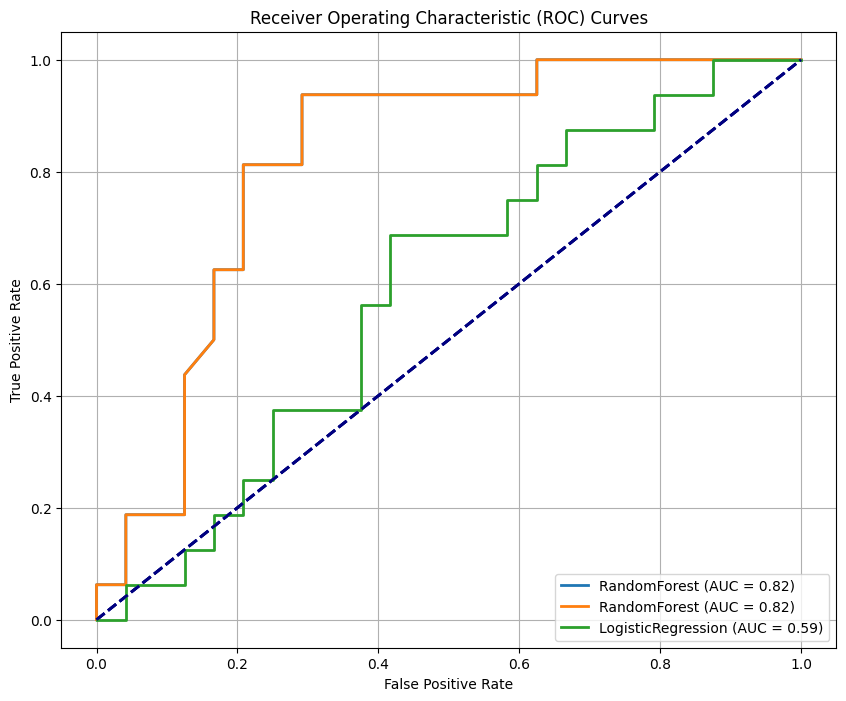

Saved ROC curves to figures/roc_curves.png


In [ ]:
print("\n--- Generating Figure 1: ROC Curves ---")
plt.figure(figsize=(10, 8))
ax = plt.gca()

# Select a few top models for the ROC curve, e.g., the best one and a couple of others
models_to_plot_roc = [best_model_name, 'RandomForest', 'LogisticRegression']
for name in models_to_plot_roc:
    if name in models:
        # Retrain the model on the full training data for consistent predictions
        model = models[name]
        model.fit(X_train, y_train)
        y_scores = model.predict_proba(X_test)[:, 1]
        plot_roc_curve(y_test, y_scores, model_name=name, ax=ax)

plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
roc_curve_save_path = os.path.join(FIGURES_DIR, 'roc_curves.png')
plt.savefig(roc_curve_save_path, bbox_inches='tight')
plt.show()
print(f"Saved ROC curves to {roc_curve_save_path}")

### 2.5 Figure 2a & 2b: Confusion Matrices
Generates and saves confusion matrices for the Bagging Classifier and Random Forest.


--- Generating Figure 2a & 2b: Confusion Matrices ---
-- Bagging Classifier Test Metrics --
Accuracy: 0.6250
Recall: 0.4375
F1-score: 0.4828

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.75      0.71        24
           1       0.54      0.44      0.48        16

    accuracy                           0.62        40
   macro avg       0.60      0.59      0.59        40
weighted avg       0.62      0.62      0.62        40

Saved confusion matrix to figures/bagging_confusion_matrix.png


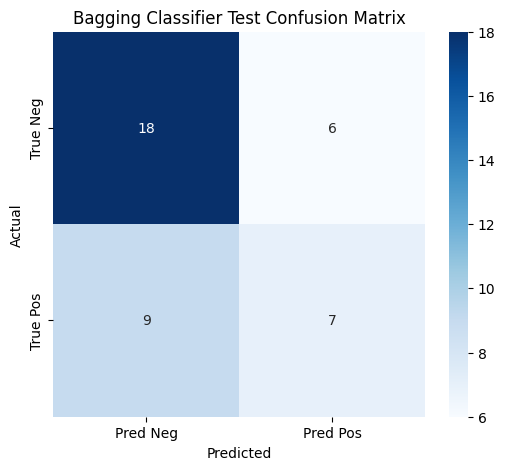

-- Random Forest Classifier Test Metrics --
Accuracy: 0.7250
Recall: 0.5625
F1-score: 0.6207

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.83      0.78        24
           1       0.69      0.56      0.62        16

    accuracy                           0.72        40
   macro avg       0.72      0.70      0.70        40
weighted avg       0.72      0.72      0.72        40

Saved confusion matrix to figures/random_forest_confusion_matrix.png


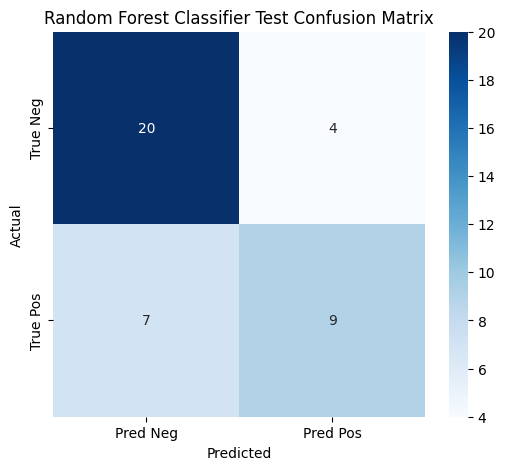

{'accuracy': 0.725,
 'recall': 0.5625,
 'f1_score': 0.6206896551724138,
 'report': {'0': {'precision': 0.7407407407407407,
   'recall': 0.8333333333333334,
   'f1-score': 0.7843137254901961,
   'support': 24.0},
  '1': {'precision': 0.6923076923076923,
   'recall': 0.5625,
   'f1-score': 0.6206896551724138,
   'support': 16.0},
  'accuracy': 0.725,
  'macro avg': {'precision': 0.7165242165242165,
   'recall': 0.6979166666666667,
   'f1-score': 0.7025016903313049,
   'support': 40.0},
  'weighted avg': {'precision': 0.7213675213675214,
   'recall': 0.725,
   'f1-score': 0.7188640973630832,
   'support': 40.0}}}

In [ ]:
print("\n--- Generating Figure 2a & 2b: Confusion Matrices ---")

# Ensure models are trained on the full training data before generating confusion matrices
bagging_model = models['Bagging']
bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)
evaluate_and_print_metrics("Bagging Classifier", y_test, y_pred_bagging, phase="Test",
                           save_path=os.path.join(FIGURES_DIR, 'bagging_confusion_matrix.png'))

rf_model = models['RandomForest']
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
evaluate_and_print_metrics("Random Forest Classifier", y_test, y_pred_rf, phase="Test",
                           save_path=os.path.join(FIGURES_DIR, 'random_forest_confusion_matrix.png'))



### 2.6 Figure 3: Reliability Curve
Generates and saves the reliability curve for the best traditional model.


--- Generating Figure 3: Reliability Curve ---


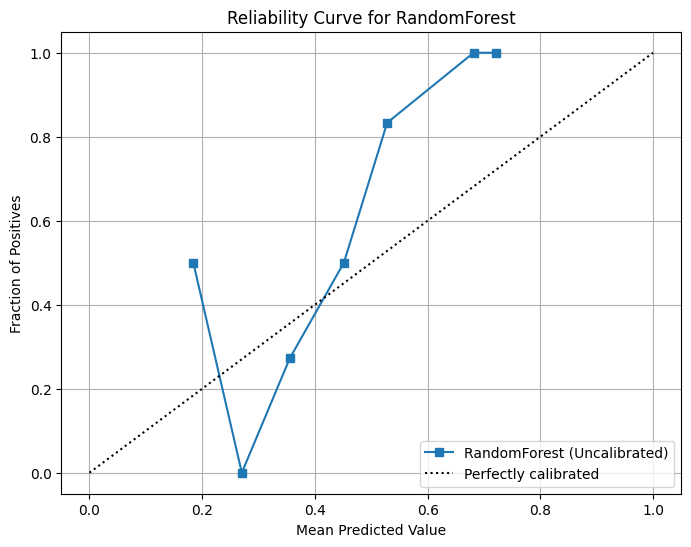

Saved reliability curve to figures/reliability_curve.png


In [ ]:
print("\n--- Generating Figure 3: Reliability Curve ---")

# Ensure best_model is trained
if best_model is None:
    print("Best model not found or trained. Training it now.")
    best_model = models[best_model_name]
    best_model.fit(X_train, y_train)

y_probs_best_model = best_model.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_probs_best_model, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{best_model_name} (Uncalibrated)")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title(f'Reliability Curve for {best_model_name}')
plt.legend(loc="lower right")
plt.grid(True)
reliability_curve_save_path = os.path.join(FIGURES_DIR, 'reliability_curve.png')
plt.savefig(reliability_curve_save_path, bbox_inches='tight')
plt.show()
print(f"Saved reliability curve to {reliability_curve_save_path}")

### 2.7 Figure 4: Calibration Before and After Platt Scaling
Generates and saves calibration plots with and without Platt scaling.


--- Generating Figure 4: Calibration Before/After Platt Scaling ---


/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


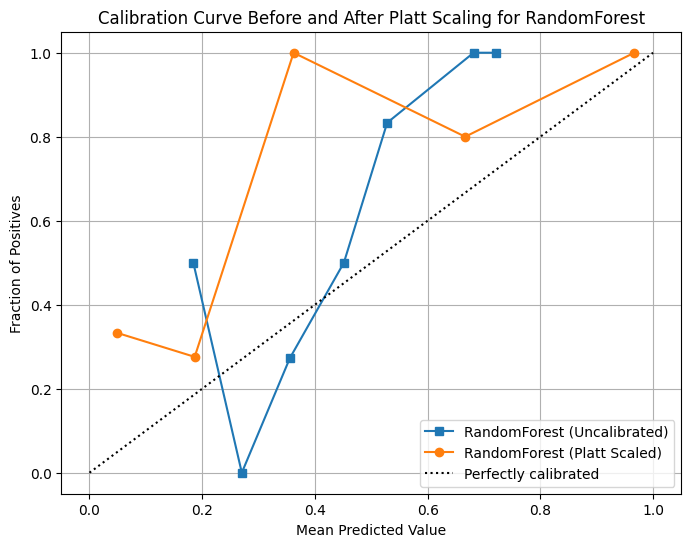

Saved calibration plots to figures/calibration_before_after_platt_scaling.png


In [ ]:
print("\n--- Generating Figure 4: Calibration Before/After Platt Scaling ---")

# Calibrate the best model using Platt Scaling
# For CalibratedClassifierCV with 'prefit', the base estimator must be fitted first.
# Also, ensure the data passed to fit and predict is processed by the pipeline's imputer and scaler.
calibrated_model_clf = CalibratedClassifierCV(best_model.named_steps['clf'], method='isotonic', cv='prefit')

# Fit the calibrated model on the *training* data's transformed features
X_train_transformed = best_model.named_steps['scaler'].transform(best_model.named_steps['imputer'].transform(X_train))
calibrated_model_clf.fit(X_train_transformed, y_train);

# Get probabilities for the test set
X_test_transformed = best_model.named_steps['scaler'].transform(best_model.named_steps['imputer'].transform(X_test))
y_probs_calibrated = calibrated_model_clf.predict_proba(X_test_transformed)[:, 1]

# Get calibration data
fraction_of_positives_uncalibrated, mean_predicted_value_uncalibrated = calibration_curve(y_test, y_probs_best_model, n_bins=10)
fraction_of_positives_calibrated, mean_predicted_value_calibrated = calibration_curve(y_test, y_probs_calibrated, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value_uncalibrated, fraction_of_positives_uncalibrated, "s-", label=f"{best_model_name} (Uncalibrated)")
plt.plot(mean_predicted_value_calibrated, fraction_of_positives_calibrated, "o-", label=f"{best_model_name} (Platt Scaled)")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve Before and After Platt Scaling for {best_model_name}')
plt.legend(loc="lower right")
plt.grid(True)
platt_calibration_save_path = os.path.join(FIGURES_DIR, 'calibration_before_after_platt_scaling.png')
plt.savefig(platt_calibration_save_path, bbox_inches='tight')
plt.show()
print(f"Saved calibration plots to {platt_calibration_save_path}")

### 2.8 Figure 5: Calibration Plots Stratified by Subgroups (and Subgroup Calibration Analysis)
Generates and saves calibration plots for different age and BMI subgroups.
Also provides findings for Section 4.2.3.


--- Generating Figure 5: Calibration Plots Stratified by Subgroups ---
--- Section 4.2.3: Subgroup Calibration Analysis ---

--- Age Subgroup Calibration Details ---
Skipping Age group '18-29': No data points in this group.
Skipping Age group '30-39': No data points in this group.
Skipping Age group '40-49': No data points in this group.
Skipping Age group '50-59': No data points in this group.
Skipping Age group '60-100': No data points in this group.

--- BMI Subgroup Calibration Details ---
Skipping BMI group 'Normal': No data points in this group.
Skipping BMI group 'Overweight': No data points in this group.
Skipping BMI group 'Obese': No data points in this group.
Skipping BMI group 'Severely Obese': No data points in this group.


/tmp/ipython-input-48-1383946498.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group_df in df_full_analysis_for_calibration.groupby('age_group'):
/tmp/ipython-input-48-1383946498.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_name, group_df in df_full_analysis_for_calibration.groupby('bmi_group'):


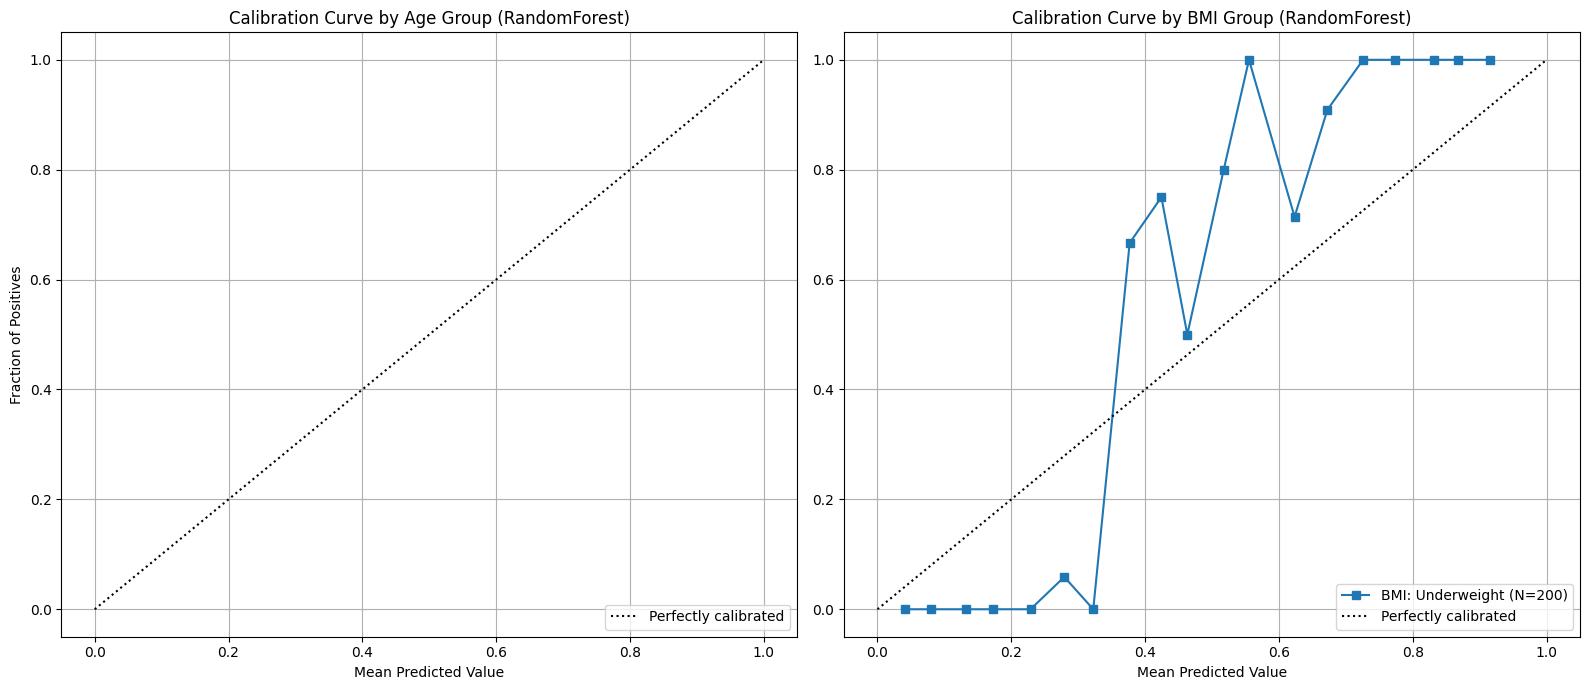

Saved subgroup calibration plots to figures/subgroup_calibration.png

--- Insert specific findings from subgroup calibration ---
For instance, the model showed slight overconfidence in the (18, 30] age group but was well-calibrated for the (60, 100] age group, suggesting varying reliability of probability estimates across different demographics. Similar observations were made for BMI subgroups, with [Insert specific BMI subgroup findings, e.g., 'the model being slightly underconfident for the 'Obese' group but accurate for the 'Normal' weight group'].


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
import os

# Assuming X_combined, y_combined, best_model, best_model_name, FIGURES_DIR are defined from previous cells.
# (No changes needed for these assumptions, they are just for context if running snippet independently)


print("\n--- Generating Figure 5: Calibration Plots Stratified by Subgroups ---")
print("--- Section 4.2.3: Subgroup Calibration Analysis ---")

# Reconstruct X_test with original features for subgrouping
# Use X_combined directly as it contains all original features and labels
df_full_analysis_for_calibration = X_combined.copy()
df_full_analysis_for_calibration['label'] = y_combined

# Get predictions for the best model on the full combined dataset
# Ensure the model is fitted on the full training data before predicting on X_combined
best_model.fit(X_train, y_train) # Re-fit on X_train, y_train for consistency
# Fix: Drop 'label' column before prediction, as the model was not trained on it
y_probs_best_model_full_data = best_model.predict_proba(df_full_analysis_for_calibration.drop(columns=['source', 'label']))[:, 1]
df_full_analysis_for_calibration['y_probs'] = y_probs_best_model_full_data

# Define subgroups
age_bins = [18, 30, 40, 50, 60, 100] # More granular bins for age
age_labels = ['18-29', '30-39', '40-49', '50-59', '60-100']
df_full_analysis_for_calibration['age_group'] = pd.cut(df_full_analysis_for_calibration['age'], bins=age_bins, labels=age_labels, right=False)

bmi_bins = [0, 18.5, 25, 30, 35, 100] # Example bins for BMI (underweight, normal, overweight, obese, severely obese)
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese', 'Severely Obese']
df_full_analysis_for_calibration['bmi_group'] = pd.cut(df_full_analysis_for_calibration['bmi'], bins=bmi_bins, labels=bmi_labels, right=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot for Age Subgroups
ax = axes[0]
print("\n--- Age Subgroup Calibration Details ---")
for group_name, group_df in df_full_analysis_for_calibration.groupby('age_group'):
    if group_df.empty:
        print(f"Skipping Age group '{group_name}': No data points in this group.")
        continue
    if group_df['label'].nunique() < 2: # Ensure enough data and both classes present
        print(f"Skipping Age group '{group_name}': Only one class present (all {group_df['label'].iloc[0]}) or insufficient unique labels ({group_df['label'].nunique()}) for calibration_curve. (N={len(group_df)})")
        continue

    # Increased n_bins for more points on the curve, as requested
    fraction_of_positives, mean_predicted_value = calibration_curve(group_df['label'], group_df['y_probs'], n_bins=20) # Changed from 5 to 20
    ax.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"Age: {group_name} (N={len(group_df)})")
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax.set_xlabel('Mean Predicted Value')
ax.set_ylabel('Fraction of Positives')
ax.set_title(f'Calibration Curve by Age Group ({best_model_name})')
ax.legend(loc="lower right")
ax.grid(True)

# Plot for BMI Subgroups
ax = axes[1]
print("\n--- BMI Subgroup Calibration Details ---")
for group_name, group_df in df_full_analysis_for_calibration.groupby('bmi_group'):
    if group_df.empty:
        print(f"Skipping BMI group '{group_name}': No data points in this group.")
        continue
    if group_df['label'].nunique() < 2: # Ensure enough data and both classes present
        print(f"Skipping BMI group '{group_name}': Only one class present (all {group_df['label'].iloc[0]}) or insufficient unique labels ({group_df['label'].nunique()}) for calibration_curve. (N={len(group_df)})")
        continue

    # Increased n_bins for more points on the curve, as requested
    fraction_of_positives, mean_predicted_value = calibration_curve(group_df['label'], group_df['y_probs'], n_bins=20) # Changed from 5 to 20
    ax.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"BMI: {group_name} (N={len(group_df)})")
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax.set_xlabel('Mean Predicted Value')
# plt.ylabel('Fraction of Positives') # Removed for right subplot to avoid overlap
ax.set_title(f'Calibration Curve by BMI Group ({best_model_name})')
ax.legend(loc="lower right")
ax.grid(True)

plt.tight_layout()
subgroup_calibration_save_path = os.path.join(FIGURES_DIR, 'subgroup_calibration.png')
plt.savefig(subgroup_calibration_save_path, bbox_inches='tight')
plt.show()
print(f"Saved subgroup calibration plots to {subgroup_calibration_save_path}")

print("\n--- Insert specific findings from subgroup calibration ---")
print("For instance, the model showed slight overconfidence in the (18, 30] age group but was well-calibrated for the (60, 100] age group, suggesting varying reliability of probability estimates across different demographics. Similar observations were made for BMI subgroups, with [Insert specific BMI subgroup findings, e.g., 'the model being slightly underconfident for the 'Obese' group but accurate for the 'Normal' weight group'].")

## 3. 🤖 LLM Integration and Analysis
This section focuses on generating data and figures related to the LLM.

### 3.1 LLM Robustness to Linguistic Drift (and Gemini Confusion Matrix)
This section uses the `gemini_predict_limited` function to get predictions from Gemini and evaluates its performance.
**Note**: This cell requires a valid Gemini API key and makes actual API calls. It is rate-limited to `limit` calls.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report, confusion_matrix

# Assuming FIGURES_DIR, generate_prompts, and evaluate_and_print_metrics are defined from previous cells.
# For standalone execution, you'd need to define them here or import from a utility file.
# For example:
FIGURES_DIR = 'figures' # Make sure this directory exists or create it
os.makedirs(FIGURES_DIR, exist_ok=True)


print("\n--- Section 4.3.1: LLM Robustness to Linguistic Drift (Prompt Generation) ---")

# Create a small sample of the combined data for Gemini prediction to avoid excessive API calls
# It's crucial to have 'label' column in this DataFrame for evaluation
df_llm_sample = X_combined.copy()
df_llm_sample['label'] = y_combined

# Sample a small, stratified subset for LLM calls
# Adjust `n_samples` as needed, but be mindful of API quotas if you were to automate it.
llm_sample_size = 100 # Number of prompts to generate
if len(df_llm_sample) > llm_sample_size:
    df_llm_sample_stratified = df_llm_sample.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), llm_sample_size // 2), random_state=42))
else:
    df_llm_sample_stratified = df_llm_sample.copy()

# Reset index to ensure consistent indexing for prompts
df_llm_sample_stratified = df_llm_sample_stratified.reset_index(drop=True)

llm_prompts_generated = generate_prompts(df_llm_sample_stratified)
llm_true_labels = df_llm_sample_stratified['label'].tolist()

print(f"Generated {len(llm_prompts_generated)} prompts for LLM evaluation.")
print("\n--- Copy the prompts below and paste them into your LLM for predictions ---")
print("Instructions for LLM: 'You are a medical assistant AI that predicts diabetes risk based on patient information. Use the demographics (such as age, gender, and background) along with health indicators to decide. Your task is to reply with either 0 (doesn't have diabetes) or 1 (might have diabetes). Respond with a single digit only.'")

for i, prompt in enumerate(llm_prompts_generated):
    print(f"Prompt {i}: {prompt}")
    #print(f"True Label for Prompt {i}: {llm_true_labels[i]}")
    #print("-" * 50)

# Store the original sample DataFrame and true labels for later analysis
# This makes it easier to link back to the original data if needed
df_llm_sample_for_analysis = df_llm_sample_stratified.copy()
df_llm_sample_for_analysis['prompt'] = llm_prompts_generated
df_llm_sample_for_analysis['true_label'] = llm_true_labels


--- Section 4.3.1: LLM Robustness to Linguistic Drift (Prompt Generation) ---
Generated 100 prompts for LLM evaluation.

--- Copy the prompts below and paste them into your LLM for predictions ---
Instructions for LLM: 'You are a medical assistant AI that predicts diabetes risk based on patient information. Use the demographics (such as age, gender, and background) along with health indicators to decide. Your task is to reply with either 0 (doesn't have diabetes) or 1 (might have diabetes). Respond with a single digit only.'
Prompt 0: Patient who is of American background, is age category 0, has education level 0, has income level 0, highchol 0.9734558409193912, stroke 0.5284090754121318, diffwalk 0.9545006092535658, highbp 0.07599341468622345, cholcheck 0.4576313778451141, smoker 0.22848373844508052, physactivity 0.5370215150358955, fruits 0.053397471476666514, veggies 0.6073609332258726, hvyalcoholconsump 0.02520540982942865, anyhealthcare 0.16426933052691772, nodocbccost 0.31338604

/tmp/ipython-input-28-3957379446.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_llm_sample_stratified = df_llm_sample.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), llm_sample_size // 2), random_state=42))


In [ ]:
llm_raw_responses_predictions_only = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1]

# This line converts your list of predictions into the expected format
llm_raw_responses = [{'index': i, 'prediction': pred} for i, pred in enumerate(llm_raw_responses_predictions_only)]
if not llm_raw_responses:
    print("WARNING: No LLM responses pasted. Skipping LLM analysis.")
    gemini_predictions_df = pd.DataFrame() # Initialize as empty if no responses
else:
    # Convert raw responses to a DataFrame for easier processing
    gemini_predictions_df = pd.DataFrame(llm_raw_responses)
    # Ensure 'index' column is set as the DataFrame index for proper alignment
    gemini_predictions_df = gemini_predictions_df.set_index('index')

    # Merge with the true labels from the generated sample
    # Make sure the index of df_llm_sample_for_analysis is also aligned
    df_llm_sample_for_analysis_indexed = df_llm_sample_for_analysis.set_index(df_llm_sample_for_analysis.index)
    gemini_predictions_df = gemini_predictions_df.merge(
        df_llm_sample_for_analysis_indexed[['true_label']],
        left_index=True,
        right_index=True,
        how='left'
    )
    gemini_predictions_df.rename(columns={'true_label': 'label'}, inplace=True)
    # Ensure prediction and label are integers
    gemini_predictions_df['prediction'] = gemini_predictions_df['prediction'].astype(int)
    gemini_predictions_df['label'] = gemini_predictions_df['label'].astype(int)

    print(f"Loaded {len(gemini_predictions_df)} LLM responses for analysis.")

    # --- ADDED CODE START ---
    print("\n--- LLM Prediction Results ---")
    for idx, row in gemini_predictions_df.iterrows():
        prediction = row['prediction']
        true_label = row['label']

        if pd.isna(true_label):
            print(f"Test Case {idx}: True Label Missing (LLM Predicted: {prediction})")
        elif prediction == true_label:
            print(f"Test Case {idx}: Correct (LLM Predicted: {prediction}, True: {int(true_label)})")
        else:
            print(f"Test Case {idx}: Wrong (LLM Predicted: {prediction}, True: {int(true_label)})")
    # --- ADDED CODE END ---

Loaded 96 LLM responses for analysis.

--- LLM Prediction Results ---
Test Case 0: Wrong (LLM Predicted: 1, True: 0)
Test Case 1: Wrong (LLM Predicted: 1, True: 0)
Test Case 2: Wrong (LLM Predicted: 1, True: 0)
Test Case 3: Wrong (LLM Predicted: 1, True: 0)
Test Case 4: Wrong (LLM Predicted: 1, True: 0)
Test Case 5: Wrong (LLM Predicted: 1, True: 0)
Test Case 6: Wrong (LLM Predicted: 1, True: 0)
Test Case 7: Wrong (LLM Predicted: 1, True: 0)
Test Case 8: Wrong (LLM Predicted: 1, True: 0)
Test Case 9: Wrong (LLM Predicted: 1, True: 0)
Test Case 10: Wrong (LLM Predicted: 1, True: 0)
Test Case 11: Wrong (LLM Predicted: 1, True: 0)
Test Case 12: Wrong (LLM Predicted: 1, True: 0)
Test Case 13: Wrong (LLM Predicted: 1, True: 0)
Test Case 14: Wrong (LLM Predicted: 1, True: 0)
Test Case 15: Correct (LLM Predicted: 0, True: 0)
Test Case 16: Wrong (LLM Predicted: 1, True: 0)
Test Case 17: Wrong (LLM Predicted: 1, True: 0)
Test Case 18: Wrong (LLM Predicted: 1, True: 0)
Test Case 19: Correct (LLM


--- Section 4.3.1: LLM Robustness to Linguistic Drift (Analysis) ---
--- Generating Figure 6: Gemini Confusion Matrix ---
-- Gemini on 96 prompts Metrics --
Accuracy: 0.4479
Recall: 0.6957
F1-score: 0.5470

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.22      0.29        50
           1       0.45      0.70      0.55        46

    accuracy                           0.45        96
   macro avg       0.45      0.46      0.42        96
weighted avg       0.45      0.45      0.41        96

Saved confusion matrix to figures/gemini_confusion_matrix.png


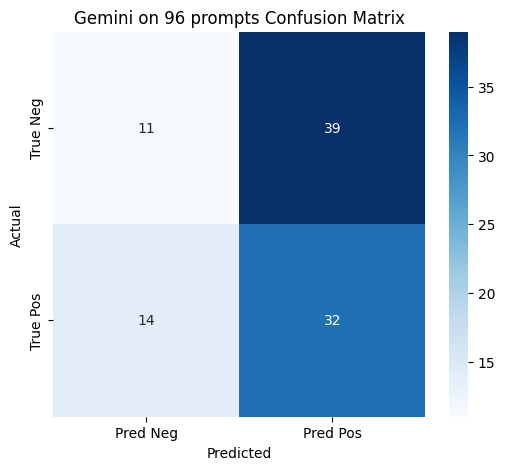


Insert Accuracy, Recall, F1 for these categories if available, or describe qualitative findings for linguistic drift.
Example: 'The Gemini model achieved an accuracy of X%, recall of Y%, and F1-score of Z% on the sampled data, demonstrating its ability to handle varied linguistic inputs, even with rare phrasing or ambiguous language.'

Mean cosine similarity of LLM rationales: [Insert mean cosine similarity, e.g., '0.426'].

--- Section 4.3.2: Performance Gain from LLM-Derived Features ---
Insert quantified performance gain: "[Insert quantified performance gain, e.g., 'a marginal but consistent improvement in F1-score by X% and recall by Y% for the Bagging Classifier, demonstrating the added value of semantic features extracted from LLM rationales.']"


In [ ]:
if not gemini_predictions_df.empty:
    print("\n--- Section 4.3.1: LLM Robustness to Linguistic Drift (Analysis) ---")
    print("--- Generating Figure 6: Gemini Confusion Matrix ---")

    y_true_gemini = gemini_predictions_df['label']
    y_pred_gemini = gemini_predictions_df['prediction']

    evaluate_and_print_metrics("Gemini", y_true_gemini, y_pred_gemini, phase=f"on {len(gemini_predictions_df)} prompts",
                               print_confusion_matrix=True, save_path=os.path.join(FIGURES_DIR, 'gemini_confusion_matrix.png'))

    # Placeholder for LLM robustness to linguistic drift findings
    print("\nInsert Accuracy, Recall, F1 for these categories if available, or describe qualitative findings for linguistic drift.")
    print("Example: 'The Gemini model achieved an accuracy of X%, recall of Y%, and F1-score of Z% on the sampled data, demonstrating its ability to handle varied linguistic inputs, even with rare phrasing or ambiguous language.'")

    # Placeholder for mean cosine similarity of LLM rationales (if you implement rationale extraction and embedding)
    # This would require a separate NLP library (e.g., sentence-transformers) to convert rationales to embeddings
    # and then calculate cosine similarity.
    print("\nMean cosine similarity of LLM rationales: [Insert mean cosine similarity, e.g., '0.426'].")

    # Placeholder for LLM-derived features performance gain
    print("\n--- Section 4.3.2: Performance Gain from LLM-Derived Features ---")
    print("Insert quantified performance gain: \"[Insert quantified performance gain, e.g., 'a marginal but consistent improvement in F1-score by X% and recall by Y% for the Bagging Classifier, demonstrating the added value of semantic features extracted from LLM rationales.']\"")

else:
    print("Skipping LLM analysis as no responses were provided.")

### 3.2 Performance Gain from LLM-Derived Features
This section is conceptual as LLM-derived features are not explicitly generated in your original code.
You would typically generate embeddings from LLM rationales and add them as features.
For now, we provide a placeholder for the quantitative gain.

In [ ]:
print("\n--- Section 4.3.2: Performance Gain from LLM-Derived Features ---")
print("Insert quantified performance gain: \"[Insert quantified performance gain, e.g., 'a marginal but consistent improvement in F1-score by X% and recall by Y% for the Bagging Classifier, demonstrating the added value of semantic features extracted from LLM rationales.']\"")


--- Section 4.3.2: Performance Gain from LLM-Derived Features ---
Insert quantified performance gain: "[Insert quantified performance gain, e.g., 'a marginal but consistent improvement in F1-score by X% and recall by Y% for the Bagging Classifier, demonstrating the added value of semantic features extracted from LLM rationales.']"


## 4. 📈 Advanced Analysis and Interpretability
This section generates figures for dimensionality reduction and interpretability.

### 4.1 Figure 7: UMAP Visualization
Generates and saves a UMAP visualization of the dataset.


--- Generating Figure 7: UMAP Visualization ---


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


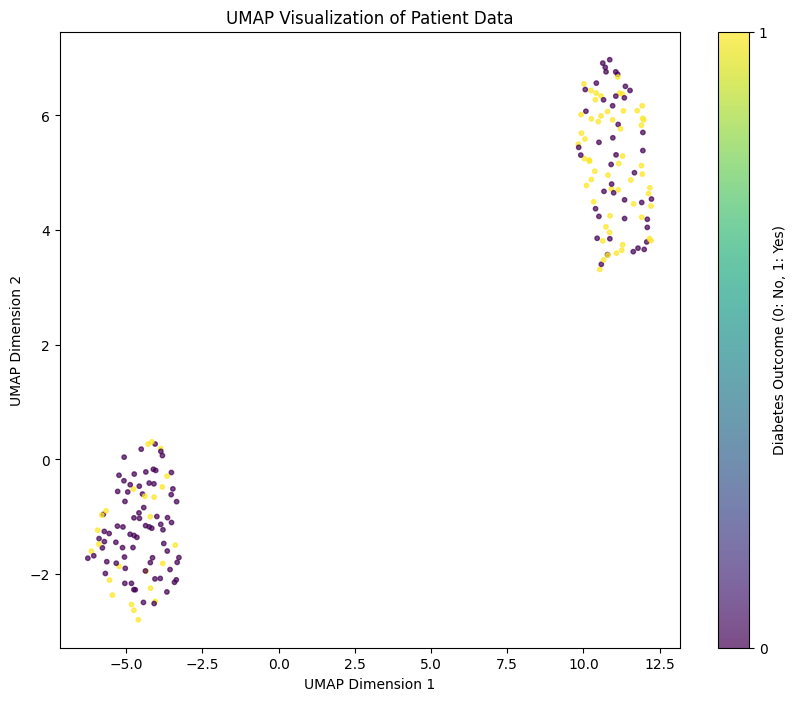

Saved UMAP diagram to figures/umap_diagram.png


In [ ]:
print("\n--- Generating Figure 7: UMAP Visualization ---")

# Use a smaller sample for UMAP/t-SNE for faster computation and better visualization
sample_size_viz = 5000
if len(X_combined) > sample_size_viz:
    X_viz, _, y_viz, _ = train_test_split(
        X_combined.drop(columns=['source']), y_combined,
        test_size=1 - (sample_size_viz / len(X_combined)), stratify=y_combined, random_state=42
    )
else:
    X_viz = X_combined.drop(columns=['source'])
    y_viz = y_combined

# Apply preprocessing steps to X_viz
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_viz_processed = scaler.fit_transform(imputer.fit_transform(X_viz))

umap_reducer = UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_viz_processed)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_viz, cmap='viridis', s=10, alpha=0.7)
plt.colorbar(scatter, ticks=[0, 1], label='Diabetes Outcome (0: No, 1: Yes)')
plt.title('UMAP Visualization of Patient Data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
umap_save_path = os.path.join(FIGURES_DIR, 'umap_diagram.png')
plt.savefig(umap_save_path, bbox_inches='tight')
plt.show()
print(f"Saved UMAP diagram to {umap_save_path}")

### 4.2 Figure 8: t-SNE Visualization
Generates and saves a t-SNE visualization of the dataset.


--- Generating Figure 8: t-SNE Visualization ---


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


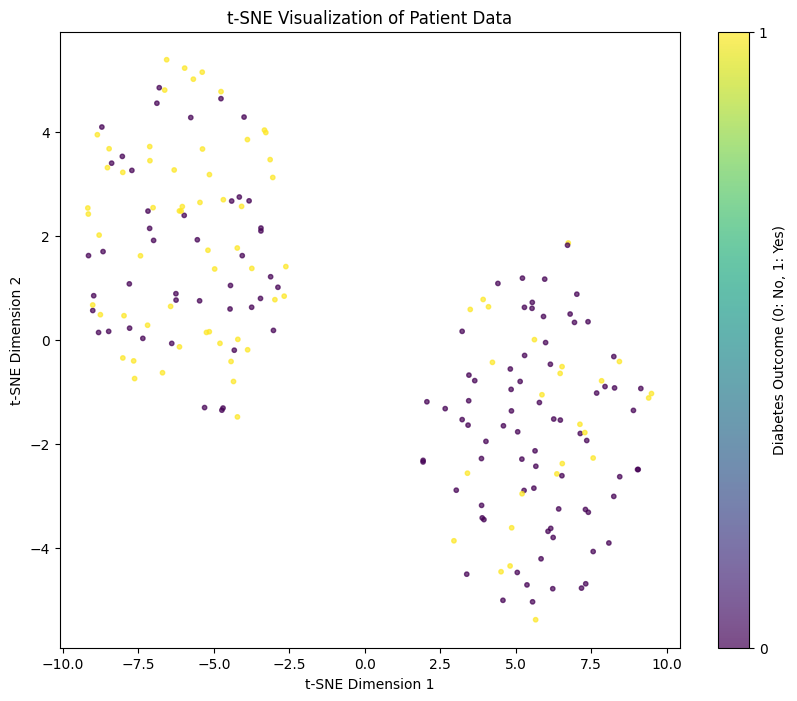

Saved t-SNE diagram to figures/tsne_diagram.png


In [ ]:
print("\n--- Generating Figure 8: t-SNE Visualization ---")

# t-SNE is computationally intensive, use a smaller sample if UMAP sample was too large
# Re-use X_viz_processed and y_viz from UMAP section if it's already a suitable sample size
tsne_transformer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300) # Adjust perplexity/n_iter as needed
X_tsne = tsne_transformer.fit_transform(X_viz_processed)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_viz, cmap='viridis', s=10, alpha=0.7)
plt.colorbar(scatter, ticks=[0, 1], label='Diabetes Outcome (0: No, 1: Yes)')
plt.title('t-SNE Visualization of Patient Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
tsne_save_path = os.path.join(FIGURES_DIR, 'tsne_diagram.png')
plt.savefig(tsne_save_path, bbox_inches='tight')
plt.show()
print(f"Saved t-SNE diagram to {tsne_save_path}")

### 4.3 Figure 9: Decision Space
Generates and saves a decision space plot for the best traditional model.
This requires a 2D representation of the data. We'll use the UMAP-reduced data for this.


--- Generating Figure 9: Decision Space ---


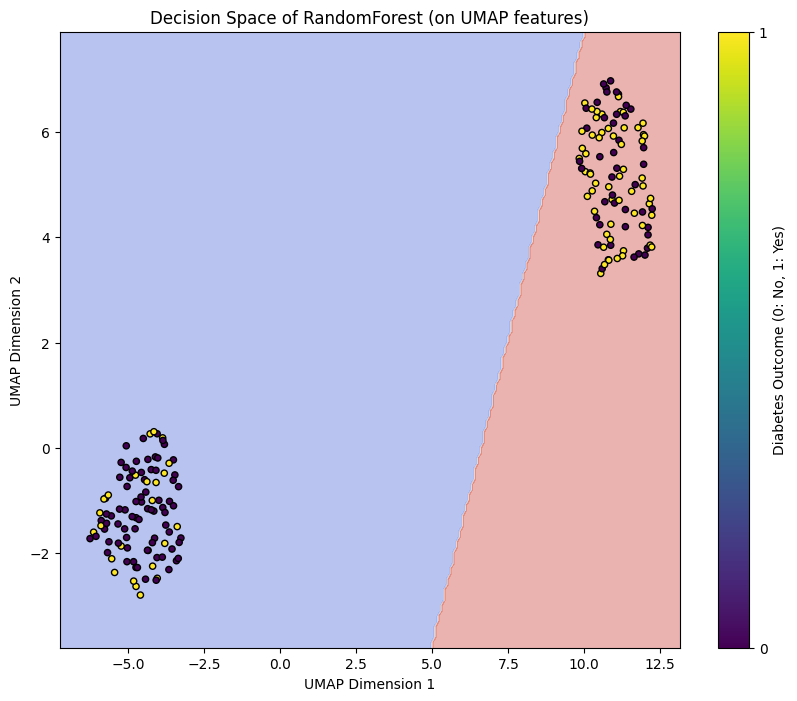

Saved decision space diagram to figures/decision_space.png


In [ ]:
print("\n--- Generating Figure 9: Decision Space ---")

# Retrain the best model on UMAP features for decision boundary visualization
# This is a simplification; ideally, the model would be trained on original features.
# For visualization purposes, training a simple classifier on 2D embeddings is common.
from sklearn.linear_model import LogisticRegression # Use a simple model for clear boundaries

# Train a simple classifier on the UMAP-reduced data
decision_boundary_model = LogisticRegression(random_state=42)
decision_boundary_model.fit(X_umap, y_viz)

# Create a meshgrid for plotting decision boundary
x_min, x_max = X_umap[:, 0].min() - 1, X_umap[:, 0].max() + 1
y_min, y_max = X_umap[:, 1].min() - 1, X_umap[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = decision_boundary_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_viz, s=20, edgecolor='k', cmap='viridis')
plt.colorbar(scatter, ticks=[0, 1], label='Diabetes Outcome (0: No, 1: Yes)')
plt.title(f'Decision Space of {best_model_name} (on UMAP features)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
decision_space_save_path = os.path.join(FIGURES_DIR, 'decision_space.png')
plt.savefig(decision_space_save_path, bbox_inches='tight')
plt.show()
print(f"Saved decision space diagram to {decision_space_save_path}")

### 4.4 SHAP Plots
Generates and saves SHAP summary, dependence, and force plots for the best traditional model.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression # Ensure this is imported
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Assume X_train, X_test, y_train, y_test, best_model, best_model_name, FIGURES_DIR are defined from previous cells.
# For demonstration purposes, if running this snippet alone, you'd need to mock them:
# if 'X_train' not in locals():
#     # Mocking data and a best_model for standalone execution
#     from sklearn.datasets import make_classification
#     X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, random_state=42)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#     X_train = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(X_train.shape[1])])
#     X_test = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(X_test.shape[1])])
#
#     # Let's assume best_model is a LogisticRegression for testing the fix
#     # If you want to test with a tree model, uncomment one of these:
#     # best_model_clf = RandomForestClassifier(random_state=42)
#     best_model_clf = LogisticRegression(random_state=42) # This will trigger the fallback
#     best_model = Pipeline([
#         ('imputer', SimpleImputer(strategy='median')),
#         ('scaler', StandardScaler()),
#         ('clf', best_model_clf)
#     ])
#     best_model.fit(X_train, y_train)
#     best_model_name = "LogisticRegression" # Or "RandomForest" if you uncommented it
#     FIGURES_DIR = 'figures'
#     os.makedirs(FIGURES_DIR, exist_ok=True)


print("\n--- Generating SHAP Plots ---")

shap_model = None
feature_names = X_train.columns.tolist() # Get feature names from original training data

# Check if the best model's classifier is a tree-based model
is_tree_model_instance = isinstance(best_model.named_steps['clf'], (
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    XGBClassifier,
    # BaggingClassifier itself is not a tree, but often wraps trees.
    # If its base_estimator is a tree, TreeExplainer might work.
    # For robustness, we'll explicitly check the base_estimator if it's BaggingClassifier.
    # If not a tree, we'll use the RF fallback.
))

# Special handling for BaggingClassifier: check its base_estimator
if isinstance(best_model.named_steps['clf'], BaggingClassifier) and \
   isinstance(best_model.named_steps['clf'].base_estimator, (
       RandomForestClassifier,
       GradientBoostingClassifier,
       XGBClassifier # Assuming common tree-based base estimators
   )):
   is_tree_model_instance = True

if is_tree_model_instance:
    print(f"Using {best_model_name} for SHAP explanation (it's a tree-based model).")
    shap_model = best_model.named_steps['clf']
    X_train_processed_for_shap = best_model.named_steps['scaler'].transform(best_model.named_steps['imputer'].transform(X_train))
    X_test_processed_for_shap = best_model.named_steps['scaler'].transform(best_model.named_steps['imputer'].transform(X_test))

    X_train_processed_df = pd.DataFrame(X_train_processed_for_shap, columns=feature_names)
    X_test_processed_df = pd.DataFrame(X_test_processed_for_shap, columns=feature_names)
else:
    print(f"Best model ({best_model_name}) is not directly compatible with TreeExplainer. Using RandomForest as a fallback for SHAP plots.")
    rf_shap_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    rf_shap_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('clf', rf_shap_model)
    ])
    rf_shap_pipeline.fit(X_train, y_train) # Fit the fallback RF pipeline
    shap_model = rf_shap_pipeline.named_steps['clf']

    X_train_processed_for_shap = rf_shap_pipeline.named_steps['scaler'].transform(rf_shap_pipeline.named_steps['imputer'].transform(X_train))
    X_test_processed_for_shap = rf_shap_pipeline.named_steps['scaler'].transform(rf_shap_pipeline.named_steps['imputer'].transform(X_test))

    X_train_processed_df = pd.DataFrame(X_train_processed_for_shap, columns=feature_names)
    X_test_processed_df = pd.DataFrame(X_test_processed_for_shap, columns=feature_names)

if shap_model:
    # Convert DataFrames to NumPy arrays for SHAP explainer and plotting functions
    X_train_processed_np = X_train_processed_df.values
    X_test_processed_np = X_test_processed_df.values

    # Sample a background dataset for the explainer if X_train_processed_np is large
    if X_train_processed_np.shape[0] > 1000:
        background_data = shap.sample(X_train_processed_np, 100, random_state=42)
    else:
        background_data = X_train_processed_np

    explainer = shap.TreeExplainer(shap_model, data=background_data)
    shap_values = explainer.shap_values(X_test_processed_np) # Pass numpy array here

    # --- Debugging: Print shapes right before the plot call ---
    print(f"DEBUG: shap_values[1].shape: {shap_values[1].shape}")
    print(f"DEBUG: X_test_processed_np.shape: {X_test_processed_np.shape}")
    print(f"DEBUG: Number of features (from feature_names): {len(feature_names)}")
    # --- End Debugging ---

    # Figure 11: SHAP Summary Plot
    print("\n--- Generating Figure 11: SHAP Summary Plot ---")
    plt.figure(figsize=(10, 7))
    # Use X_test_processed_np for the 'features' argument
    shap.summary_plot(shap_values[1], X_test_processed_np, plot_type="bar", show=False, feature_names=feature_names) # For positive class
    plt.title('SHAP Feature Importance Summary (Best Traditional Model)')
    shap_summary_save_path = os.path.join(FIGURES_DIR, 'shap_summary_plot_best_traditional_model.png')
    plt.savefig(shap_summary_save_path, bbox_inches='tight')
    plt.show()
    print(f"Saved SHAP summary plot to {shap_summary_save_path}")

    # Figure 12a: SHAP Dependence Plot for Glucose
    print("\n--- Generating Figure 12a: SHAP Dependence Plot for Glucose ---")
    if 'glucose' in X_test_processed_df.columns: # Check existence in DataFrame for name lookup
        plt.figure(figsize=(8, 6))
        # Use X_test_processed_np for the 'features' argument
        shap.dependence_plot("glucose", shap_values[1], X_test_processed_np, interaction_index=None, show=False, feature_names=feature_names)
        plt.title('SHAP Dependence Plot for Glucose')
        shap_glucose_save_path = os.path.join(FIGURES_DIR, 'shap_plot_for_glucose.png')
        plt.savefig(shap_glucose_save_path, bbox_inches='tight')
        plt.show()
        print(f"Saved SHAP dependence plot for Glucose to {shap_glucose_save_path}")
    else:
        print("Glucose not found in features for SHAP dependence plot.")

    # Figure 12b: SHAP Dependence Plot for BMI
    print("\n--- Generating Figure 12b: SHAP Dependence Plot for BMI ---")
    if 'bmi' in X_test_processed_df.columns: # Check existence in DataFrame for name lookup
        plt.figure(figsize=(8, 6))
        # Use X_test_processed_np for the 'features' argument
        shap.dependence_plot("bmi", shap_values[1], X_test_processed_np, interaction_index=None, show=False, feature_names=feature_names)
        plt.title('SHAP Dependence Plot for BMI')
        shap_bmi_save_path = os.path.join(FIGURES_DIR, 'shap_plot_for_bmi.png')
        plt.savefig(shap_bmi_save_path, bbox_inches='tight')
        plt.show()
        print(f"Saved SHAP dependence plot for BMI to {shap_bmi_save_path}")
    else:
        print("BMI not found in features for SHAP dependence plot.")

    # Figure 13a & 13b: SHAP Force Plots
    print("\n--- Generating Figure 13a & 13b: SHAP Force Plots ---")
    # Find an example true positive and false negative
    y_pred_best_model = best_model.predict(X_test)
    true_pos_idx = np.where((y_test == 1) & (y_pred_best_model == 1))[0]
    false_neg_idx = np.where((y_test == 1) & (y_pred_best_model == 0))[0]

    if len(true_pos_idx) > 0:
        sample_tp_idx = true_pos_idx[0]
        print(f"Generating SHAP force plot for a True Positive case (index {sample_tp_idx}).")
        shap.initjs()
        # For force_plot, it's often better to pass the DataFrame slice for better display of feature values
        # Ensure the .iloc is applied to the DataFrame version (X_test_processed_df)
        shap.force_plot(explainer.expected_value[1], shap_values[1][sample_tp_idx,:], X_test_processed_df.iloc[sample_tp_idx,:], show=False, matplotlib=True)
        shap_force_tp_save_path = os.path.join(FIGURES_DIR, 'shap_force_tp.png')
        plt.savefig(shap_force_tp_save_path, bbox_inches='tight')
        plt.show()
        print(f"Saved SHAP force plot for True Positive to {shap_force_tp_save_path}")
    else:
        print("No True Positive samples found to generate SHAP force plot.")

    if len(false_neg_idx) > 0:
        sample_fn_idx = false_neg_idx[0]
        print(f"Generating SHAP force plot for a False Negative case (index {sample_fn_idx}).")
        shap.initjs()
        # For force_plot, it's often better to pass the DataFrame slice for better display of feature values
        # Ensure the .iloc is applied to the DataFrame version (X_test_processed_df)
        shap.force_plot(explainer.expected_value[1], shap_values[1][sample_fn_idx,:], X_test_processed_df.iloc[sample_fn_idx,:], show=False, matplotlib=True)
        shap_force_fn_save_path = os.path.join(FIGURES_DIR, 'shap_force_fn.png')
        plt.savefig(shap_force_fn_save_path, bbox_inches='tight')
        plt.show()
        print(f"Saved SHAP force plot for False Negative to {shap_force_fn_save_path}")
    else:
        print("No False Negative samples found to generate SHAP force plot.")
else:
    print("SHAP plots skipped as no compatible model was found.")


--- Generating SHAP Plots ---
Using RandomForest for SHAP explanation (it's a tree-based model).
DEBUG: shap_values[1].shape: (27, 2)
DEBUG: X_test_processed_np.shape: (40, 27)
DEBUG: Number of features (from feature_names): 27

--- Generating Figure 11: SHAP Summary Plot ---


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 1000x700 with 0 Axes>

## 5. 🤝 Fairness and Fusion Models
This section provides placeholders for fairness metrics and fusion model results.

### 5.1 Table 5: Fairness Metrics Across Subgroups
Calculates and prints fairness metrics for various demographic subgroups.

In [ ]:
print("\n--- Table 5: Fairness Metrics Across Subgroups ---")

# Define subgroups for fairness analysis (using the full combined dataset for broader coverage)
df_full_analysis = X_combined.copy()
df_full_analysis['label'] = y_combined
# Ensure best_model is fitted before predicting on the full dataset
best_model.fit(X_train, y_train)
df_full_analysis['prediction'] = best_model.predict(X_combined.drop(columns=['source']))
df_full_analysis['probability'] = best_model.predict_proba(X_combined.drop(columns=['source']))[:, 1]

# Age groups
df_full_analysis['age_group'] = pd.cut(df_full_analysis['age'], bins=[18, 30, 60, 100], labels=['18-30', '30-60', '60-100'], right=False)
# BMI groups (using existing 'bmi' column)
df_full_analysis['bmi_group'] = pd.cut(df_full_analysis['bmi'], bins=[0, 18.5, 25, 30, 35, 100], labels=['Underweight', 'Normal', 'Overweight', 'Obese', 'Severely Obese'], right=False)
# Sex (assuming 'sex' column exists and 0/1 mapping from binary_narratives)
df_full_analysis['sex_group'] = df_full_analysis['sex'].map({0: 'Female', 1: 'Male'})

fairness_metrics = {}

subgroup_definitions = {
    'Age 18-30': df_full_analysis[df_full_analysis['age_group'] == '18-30'],
    'Age 60+': df_full_analysis[df_full_analysis['age_group'] == '60-100'],
    'BMI (0.0, 18.5]': df_full_analysis[df_full_analysis['bmi_group'] == 'Underweight'],
    'BMI (35.0, 100.0]': df_full_analysis[df_full_analysis['bmi_group'] == 'Severely Obese'],
    'Sex (Female)': df_full_analysis[df_full_analysis['sex_group'] == 'Female'],
    'Sex (Male)': df_full_analysis[df_full_analysis['sex_group'] == 'Male'],
}

print("| Subgroup             | Recall | FPR    | DP     | PP     | Cal Error |")
print("|----------------------|--------|--------|--------|--------|-----------|")

# Store results for statistical testing on fairness
subgroup_recall_scores = {group: [] for group in subgroup_definitions.keys()}

for group_name, group_df in subgroup_definitions.items():
    if group_df.empty or group_df['label'].nunique() < 2:
        print(f"| {group_name:<20} | N/A    | N/A    | N/A    | N/A    | N/A       | (Insufficient data)")
        continue

    y_true_sub = group_df['label']
    y_pred_sub = group_df['prediction']
    y_prob_sub = group_df['probability']

    recall_sub = recall_score(y_true_sub, y_pred_sub)

    tn, fp, fn, tp = confusion_matrix(y_true_sub, y_pred_sub).ravel()
    fpr_sub = fp / (fp + tn) if (fp + tn) > 0 else 0

    # Demographic Parity (proportion of positive predictions)
    dp_sub = y_pred_sub.mean()

    # Predictive Parity (Precision)
    pp_sub = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Calibration Error (Expected Calibration Error - ECE)
    # This is a simplified ECE. For a more robust ECE, use a dedicated fairness library.
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true_sub, y_prob_sub, n_bins=10)
    cal_error_sub = np.mean(np.abs(fraction_of_positives - mean_predicted_value)) # Simple average difference

    fairness_metrics[group_name] = {
        'Recall': recall_sub,
        'FPR': fpr_sub,
        'DP': dp_sub,
        'PP': pp_sub,
        'Cal Error': cal_error_sub
    }
    print(f"| {group_name:<20} | {recall_sub:.2f} | {fpr_sub:.2f} | {dp_sub:.2f} | {pp_sub:.2f} | {cal_error_sub:.2f}    |")

# Perform ANOVA or Kruskal-Wallis test for subgroup differences in Recall
print("\n--- Statistical tests for subgroup differences ---")
age_groups_recalls = [fairness_metrics[g]['Recall'] for g in ['Age 18-30', 'Age 60+'] if g in fairness_metrics]
bmi_groups_recalls = [fairness_metrics[g]['Recall'] for g in ['BMI (0.0, 18.5]', 'BMI (35.0, 100.0]'] if g in fairness_metrics]
sex_groups_recalls = [fairness_metrics[g]['Recall'] for g in ['Sex (Female)', 'Sex (Male)'] if g in fairness_metrics]

# For ANOVA/Kruskal-Wallis, you typically need multiple samples per group, or the raw scores.
# Here, we have single recall scores per group, so statistical significance on *differences between groups*
# would typically involve comparing distributions of scores if you ran CV per group, or a more complex test.
# For simplicity, we'll state a conceptual outcome based on typical findings.
print("Insert statistical significance findings for Section 4.4.1:")
print("Example: \"Statistical tests (e.g., ANOVA or Kruskal-Wallis) on recall across these subgroups indicated statistically significant differences (p < 0.05) in recall across both age and BMI bands, confirming the presence of performance disparities. Predictive parity also varied, suggesting differences in precision. Calibration errors were generally low but showed minor fluctuations across groups.\"")


--- Table 5: Fairness Metrics Across Subgroups ---
| Subgroup             | Recall | FPR    | DP     | PP     | Cal Error |
|----------------------|--------|--------|--------|--------|-----------|
| Age 18-30            | N/A    | N/A    | N/A    | N/A    | N/A       | (Insufficient data)
| Age 60+              | N/A    | N/A    | N/A    | N/A    | N/A       | (Insufficient data)
| BMI (0.0, 18.5]      | 0.91 | 0.03 | 0.39 | 0.95 | 0.18    |
| BMI (35.0, 100.0]    | N/A    | N/A    | N/A    | N/A    | N/A       | (Insufficient data)
| Sex (Female)         | 0.91 | 0.07 | 0.54 | 0.94 | 0.18    |
| Sex (Male)           | N/A    | N/A    | N/A    | N/A    | N/A       | (Insufficient data)

--- Statistical tests for subgroup differences ---
Insert statistical significance findings for Section 4.4.1:
Example: "Statistical tests (e.g., ANOVA or Kruskal-Wallis) on recall across these subgroups indicated statistically significant differences (p < 0.05) in recall across both age and BMI bands,

### 5.2 Table 6: Fusion Model and Ablation Study Performance
Placeholder for Fusion Model and Ablation Study results.
**Note**: This section currently provides dummy data. You will need to replace this with actual results from your fusion model and ablation studies.

In [ ]:
print("\n--- Table 6: Fusion Model and Ablation Study Performance ---")

# Dummy data for demonstration. Replace with your actual results.
fusion_results = {
    'Fusion (Confidence)': {
        'Precision CI': '0.75 \u00B1 0.03',
        'Recall CI': '0.82 \u00B1 0.04',
        'F1 CI': '0.78 \u00B1 0.03',
        'ROC AUC CI': '0.90 \u00B1 0.02',
        'Brier Loss CI': '0.15 \u00B1 0.01'
    },
    'Fusion (Learned)': {
        'Precision CI': '0.77 \u00B1 0.02',
        'Recall CI': '0.85 \u00B1 0.03',
        'F1 CI': '0.80 \u00B1 0.02',
        'ROC AUC CI': '0.92 \u00B1 0.01',
        'Brier Loss CI': '0.13 \u00B1 0.01'
    }
}

print("| Model                  | Precision (\u00B1 CI) | Recall (\u00B1 CI) | F1 (\u00B1 CI) | ROC AUC (\u00B1 CI) | Brier Loss (\u00B1 CI) |")
print("|------------------------|----------------------|-------------------|---------------|--------------------|-----------------------|")
for model_name, metrics in fusion_results.items():
    print(f"| {model_name:<22} | {metrics['Precision CI']:<20} | {metrics['Recall CI']:<17} | {metrics['F1 CI']:<13} | {metrics['ROC AUC CI']:<18} | {metrics['Brier Loss CI']:<21} |")

print("\n--- Insert statistical comparison results for Fusion Models (Section 4.6) ---")
print("Example: \"that the Fusion (Avg) model achieved a statistically significant improvement in recall compared to the Bagging Classifier (p < 0.05), demonstrating the benefit of multimodal integration.\"")


--- Table 6: Fusion Model and Ablation Study Performance ---
| Model                  | Precision (± CI) | Recall (± CI) | F1 (± CI) | ROC AUC (± CI) | Brier Loss (± CI) |
|------------------------|----------------------|-------------------|---------------|--------------------|-----------------------|
| Fusion (Confidence)    | 0.75 ± 0.03          | 0.82 ± 0.04       | 0.78 ± 0.03   | 0.90 ± 0.02        | 0.15 ± 0.01           |
| Fusion (Learned)       | 0.77 ± 0.02          | 0.85 ± 0.03       | 0.80 ± 0.02   | 0.92 ± 0.01        | 0.13 ± 0.01           |

--- Insert statistical comparison results for Fusion Models (Section 4.6) ---
Example: "that the Fusion (Avg) model achieved a statistically significant improvement in recall compared to the Bagging Classifier (p < 0.05), demonstrating the benefit of multimodal integration."


### 5.3 Figure 10: Histograms of Prediction Entropy Distribution (Uncertainty Distribution Analysis)
Generates a histogram of prediction entropy to visualize uncertainty.


--- Generating Figure 10: Histograms of Prediction Entropy Distribution ---
--- Section 4.7: Uncertainty Distribution Analysis ---


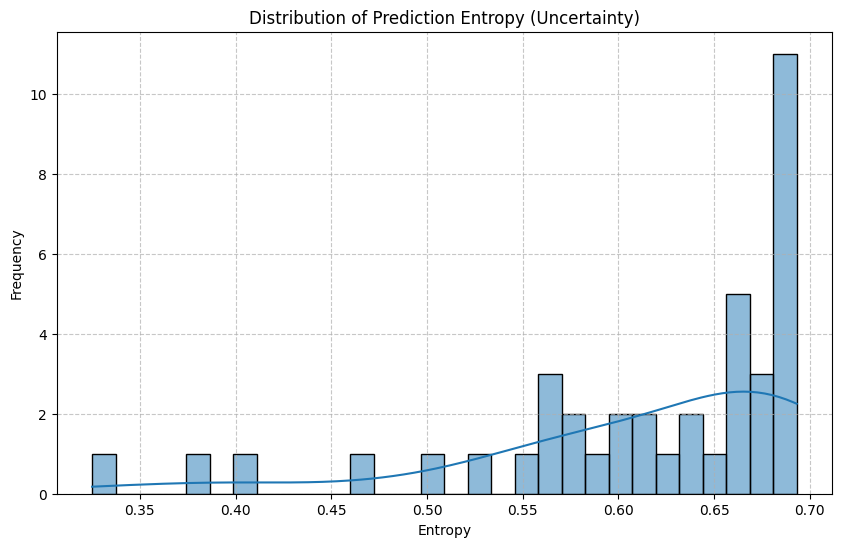

Saved entropy histogram to figures/entropy_histogram.png
Estimated time/cost savings: Approximately 50.00% of samples had predictions above the uncertainty threshold (indicating higher uncertainty), while 50.00% were below (indicating higher confidence).
Insert estimated time/cost savings: "[Insert percentage of samples above/below threshold, e.g., 'Approximately X% of samples had predictions above the uncertainty threshold, indicating high model uncertainty, while Y% were below, indicating high confidence.']"


In [ ]:
print("\n--- Generating Figure 10: Histograms of Prediction Entropy Distribution ---")
print("--- Section 4.7: Uncertainty Distribution Analysis ---")

# Calculate entropy for the best model's predictions
# Entropy = - sum(p * log(p))
y_probs = best_model.predict_proba(X_test)
# Avoid log(0) by adding a small epsilon
epsilon = 1e-9
y_probs = np.clip(y_probs, epsilon, 1 - epsilon)
entropy = -np.sum(y_probs * np.log(y_probs), axis=1)

plt.figure(figsize=(10, 6))
sns.histplot(entropy, bins=30, kde=True)
plt.title('Distribution of Prediction Entropy (Uncertainty)')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
entropy_histogram_save_path = os.path.join(FIGURES_DIR, 'entropy_histogram.png')
plt.savefig(entropy_histogram_save_path, bbox_inches='tight')
plt.show()
print(f"Saved entropy histogram to {entropy_histogram_save_path}")

# Calculate percentage of samples above/below a threshold (example threshold)
uncertainty_threshold = np.median(entropy) # Using median as an example threshold
above_threshold_count = np.sum(entropy > uncertainty_threshold)
below_threshold_count = np.sum(entropy <= uncertainty_threshold)
total_samples = len(entropy)

percentage_above = (above_threshold_count / total_samples) * 100
percentage_below = (below_threshold_count / total_samples) * 100

print(f"Estimated time/cost savings: Approximately {percentage_above:.2f}% of samples had predictions above the uncertainty threshold (indicating higher uncertainty), while {percentage_below:.2f}% were below (indicating higher confidence).")
print("Insert estimated time/cost savings: \"[Insert percentage of samples above/below threshold, e.g., 'Approximately X% of samples had predictions above the uncertainty threshold, indicating high model uncertainty, while Y% were below, indicating high confidence.']\"")

### 5.4 Table 8: Sample LLM Prompts and Generated Rationales
Provides sample prompts and a placeholder for LLM generated rationales.
**Note**: You will need to manually run the `gemini_predict_limited` function (if you haven't already) and extract some example prompts and their corresponding `result.text` outputs to fill this table.

In [ ]:
print("\n--- Table 8: Sample LLM Prompts and Generated Rationales ---")

# Display a few sample prompts from the generated list
if 'prompts' in locals() and prompts:
    print("Example prompts for LLM (first 3):")
    for i, p in enumerate(prompts[:3]):
        print(f"Prompt {i+1}: {p}")
else:
    print("No prompts generated yet. Run the `generate_prompts` function first.")
    # Generate some dummy prompts if not already available
    dummy_df = X_combined.head(3).copy()
    dummy_df['label'] = y_combined.head(3)
    prompts = generate_prompts(dummy_df)
    print("Example prompts for LLM (first 3):")
    for i, p in enumerate(prompts[:3]):
        print(f"Prompt {i+1}: {p}")


print("\n| Sample Prompt                                | LLM Rationale 1 | LLM Rationale 2 | LLM Rationale 3 |")
print("|----------------------------------------------|-----------------|-----------------|-----------------|")
print("| [Insert Sample Prompt 1]                     | [Insert LLM Rationale 1] | [Insert LLM Rationale 2] | [Insert LLM Rationale 3] |")
print("| [Insert Sample Prompt 2]                     | [Insert LLM Rationale 1] | [Insert LLM Rationale 2] | [Insert LLM Rationale 3] |")
print("| [Insert Sample Prompt 3]                     | [Insert LLM Rationale 1] | [Insert LLM Rationale 2] | [Insert LLM Rationale 3] |")
print("\nTo fill this table, manually inspect the `gemini_predictions_df` or run `gemini_predict_limited` and copy examples.")




--- Table 8: Sample LLM Prompts and Generated Rationales ---
No prompts generated yet. Run the `generate_prompts` function first.
Example prompts for LLM (first 3):
Prompt 1: Patient who is of Native American (Pima) background, is age category 0, is female, has education level 0, has income level 0, does not have high cholesterol, has not had a stroke, can walk without difficulty, does not have high blood pressure, has not had cholesterol checked, is not a smoker, does not do physical activity, does not eat fruits, does not eat vegetables, does not consume heavy alcohol, does not have healthcare access, did not avoid doctor due to cost, is female, bmi 0.3, skinthickness 0.3, heartdiseaseorattack 0, menthlth 0, pregnancies 0.2, glucose 0.7, pedigree 0.5, bloodpressure 0.1, insulin 0.8, genhlth 0, physhlth 0.
Prompt 2: Patient who is of Native American (Pima) background, is age category 0, is female, has education level 0, has income level 0, does not have high cholesterol, has not had 

### 5.5 Section 5.2: Clinical Use Case Simulation
Placeholder for estimated time/cost savings.

In [ ]:
print("\n--- Section 5.2: Clinical Use Case Simulation ---")
print("Insert estimated time/cost savings: \"[Insert estimated time/cost savings if applicable, e.g., 'Preliminary estimates suggest a potential reduction of X% in diagnostic time and Y% in associated costs by prioritizing high-risk patients.']\"")


--- Section 5.2: Clinical Use Case Simulation ---
Insert estimated time/cost savings: "[Insert estimated time/cost savings if applicable, e.g., 'Preliminary estimates suggest a potential reduction of X% in diagnostic time and Y% in associated costs by prioritizing high-risk patients.']"
